#### 1. Running QISKit code on a real IBM Q device

In the last lab, we used QISKit to run quantum simulations on a local simulator. However, we can use the IBM Q API token to submit the code to an actual quantum computer! The example below shows how to setup and submit code to run on an IBM Q device. 

If you have followed the instructions for last week's lab you should already have a Qconfig.py file in your home directory, which has your IBM Q API token. If not, please follow the instructions from the Canvas announcement last week (https://canvas.harvard.edu/courses/40754/discussion_topics/299121). Once you have the Qconfig.py file set up, you can import it in your notebook and use set_api to use your IBM Q token, as shown below.

In [17]:
from qiskit import QuantumProgram
from qiskit.tools.visualization import plot_histogram
from qutip import *
import Qconfig
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

Q_program = QuantumProgram()
Q_program.set_api(Qconfig.APItoken, Qconfig.config['url']) # set the APIToken and API url

/anaconda/lib/python3.6/site-packages/qiskit/_quantumprogram.py:707: DeprecationWarning: set_api() will be deprecated in upcoming versions (>0.5.0). Using the API object instead is recommended.
  "Using the API object instead is recommended.", DeprecationWarning)


Use the command below to check available devices. If the set_api command has worked you should see the following real devices ibmqx4, ibmqx5, and ibmqx2, along with the local simulators.

In [2]:
Q_program.available_backends()

['ibmqx2',
 'ibmqx5',
 'ibmqx4',
 'ibmqx_hpc_qasm_simulator',
 'ibmqx_qasm_simulator',
 'local_qasm_simulator',
 'local_clifford_simulator',
 'local_qiskit_simulator',
 'local_unitary_simulator']

The status of any given backend can be found by running the following command, where backend_name is the name of one of the devices. Detailed information about each of the backends can be found here: https://github.com/QISKit/ibmqx-backend-information/tree/master/backends

In [3]:
Q_program.get_backend_status('ibmqx4')

{'available': True, 'backend': 'ibmqx4', 'busy': False, 'pending_jobs': 11}

For compiling and running the code on a selectected backend, use the execute command as shown below. *Note*: Since you get limited credits with your free IBM Q account, use your credits wisely. Make sure that your code is doing what you expect by excuting it on a local backend such as ibmqx_qasm_simulator before submiting to an IBM Q device.

In [ ]:
backend = 'ibmqx2'   # Backend where you execute your program. Check the status of the device before submitting
circuits = ['Q_circuit']   # Group of quantum circuits to execute
shots = 1024           # Number of shots to run the program (experiment); maximum is 8192 shots.
max_credits = 3          # Maximum number of credits to spend on executions. 
wait = 10   # Time in seconds to wait before checking if the execution is completed.
timeout = 240 # Time in seconds to wait before timeout of execution
result_real = Q_program.execute(circuits, backend, shots=shots, max_credits=max_credits, wait=wait, timeout=timeout)

Once your job has completed execution, you can access the result using the get_counts function as shown below.

In [ ]:
result_real.get_counts('Q_circuit')

#### 2. A Quantum circuit problem to run on IBM Q

We have worked with the Deutsch Josza Algorithm a few times, but now we are going to run it once more, this time on an actual quantum computer! One can think of this as either a check on our theory of quantum computation or on IBM's experimental implementation. Recall that the Deutsch Jozsa Algorithm helps determine with a boolean function f(x) is constant (returns the same value for all strings) or balanced (returns 1 for half the strings and 0 for the other half). Here is the quantum circuit for the algorithm with n qubits and 1 ancillary bit.
![hyperlink](https://www.dropbox.com/s/dojla2udumgrcio/DJ_Alg.png?raw=1)
Remember that $U_{f}$, the oracle, takes $\left|x\right>\left|y\right>\mapsto \left|x\right>\left|y \oplus f(x)\right>$ 

a) Find a unitary gate $U_{f}$ taking
\begin{equation}
\left|x_{1}\right>\left|x_{2}\right>\left|y\right> \mapsto \left|x_{1}\right>\left|x_{2}\right>\left|y \oplus x_{1} \oplus x_{2}\right>
\end{equation}
where $x_{1}, x_{2}, y$ are binary bits 0 or 1 and $\oplus$ is binary addition. Figure out how to write this unitary gate with CNOT gates. Is the function $f(x)$ constant or balanced?

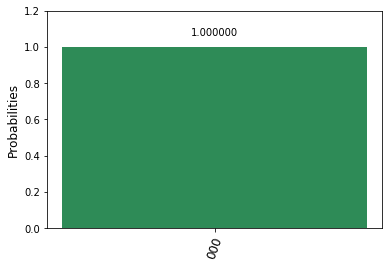

In [4]:
# generating the basic U_f gate using Qiskit circuit
# initialize circuit parameters
qp1 = QuantumProgram()
N = 3 # number of qubits
q1 = qp1.create_quantum_register("q1", N) # quantum registers (3)
c1 = qp1.create_classical_register("c1", N) # classical registers (3)
# initialize the circuit
p1_circuit = qp1.create_circuit("p1_circuit", [q1], [c1])
# add gates
p1_circuit.cx(q1[0], q1[1]) # CNOT, control 0, target 1
p1_circuit.cx(q1[0], q1[2]) # CNOT, control 0, target 2
# measure both qubits
p1_circuit.measure(q1[0], c1[0]) # quantum register 0 mapped to classical 0
p1_circuit.measure(q1[1], c1[1]) # quantum register 1 mapped to classical 1
p1_circuit.measure(q1[2], c1[2]) # quantum register 2 mapped to classical 2
# execute the circuit
results1 = qp1.execute("p1_circuit")
# plot the measurement results
plot_histogram(results1.get_counts("p1_circuit"))

# Is the function f(x) constant or balanced?

The function f(x) here represents the XOR_2 (modulo 2 addition) of x_1 and x_2. This function returns 0 on half of its inputs and returns 1 on half of its inputs and is therefore balanced.

b) Now consider the following circuit for $U_{f}$. Is this function constant or balanced? Can you give an intuitive explanation for the answer based on the properties of X and CNOT gates?
![hyperlink](https://www.dropbox.com/s/1lu8awd539q7nrg/f2.png?raw=1)

# Is this circuit constant or balanced?

This circuit for U_f here is a constant function. The first two rails contain two X gates each, which we know cancel to the identity (inverting something twice returns the original value) and thus the first two rails will always return the same output as their input. For the third rail, we perform the CNOT gates on both rails before and after the bit flip. This means that whether the top two rails were |0> or |1> is irrelevant, one pair of CNOT gates will cause a flip and one won't, whichever one it is depends on what was the input fed to these two rails. Therefore, no matter what the states on the top two rails are, we will always return the same state and the function is constant.

c) Create two versions of the Deutsch Jozsa Algorithm, one for each of the unitaries above and run your code on the ibmqx4 backend. Note that you are only using three of the five qubits available to you. However, be warned that only certain connections are possible between the qubits, so you will not be able to choose any three qubits at random to build your circuit. Looking at the diagram for ibmqx4 may be helpful (follow the link above to get more details about the configuration of ibmqx4). Arrows denote possible control-to-target relationships.

![hyperlink](https://www.dropbox.com/s/x4xddw37nq2fn9d/ibmqx4.png?raw=1)

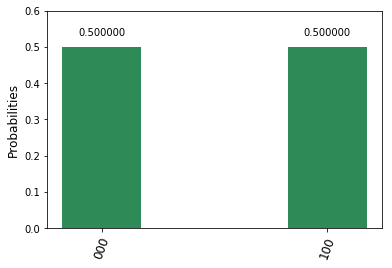

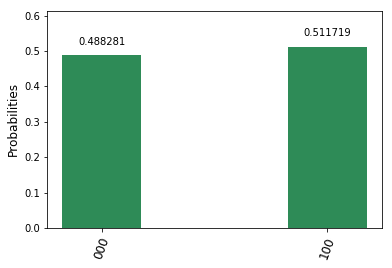

KeyboardInterrupt: 

In [71]:
# we makre sure the mapping works with IBM Q, using qubits 1, 2 and 3

# Generating the circuit from part (a)
# initialize circuit parameters
qp2 = QuantumProgram()
N = 3 # number of qubits
q2 = qp2.create_quantum_register("q2", N) # quantum registers (3)
c2 = qp2.create_classical_register("c2", N) # classical registers (3)
# initialize the circuit
DeutschJosza1 = qp2.create_circuit("DeutschJosza1", [q2], [c2])
# add gates
DeutschJosza1.h(q2[0]) # Hadamard acting on first qubit
DeutschJosza1.h(q2[1]) # Hadamard acting on second qubit
DeutschJosza1.h(q2[2]) # Hadamard acting on third qubit
""" Begin U_f """
DeutschJosza1.cx(q2[2], q2[0]) # CNOT, control 2, target 0
DeutschJosza1.cx(q2[2], q2[1]) # CNOT, control 2, target 1
""" End U_f """
DeutschJosza1.h(q2[0]) # Hadamard acting on first qubit
DeutschJosza1.h(q2[1]) # Hadamard acting on second qubit    
# measure both qubits
DeutschJosza1.measure(q2[0], c2[0]) # quantum register 0 mapped to classical 0
DeutschJosza1.measure(q2[1], c2[1]) # quantum register 1 mapped to classical 1
DeutschJosza1.measure(q2[2], c2[2]) # quantum register 2 mapped to classical 2
# execute the circuit
DeutschJosza1 = qp2.execute("DeutschJosza1")
# plot the measurement results
plot_histogram(DeutschJosza1.get_counts("DeutschJosza1"))

# Generating the circuit from part (b)
# initialize circuit parameters
qp3 = QuantumProgram()
N = 3 # number of qubits
q3 = qp3.create_quantum_register("q3", N) # quantum registers (3)
c3 = qp3.create_classical_register("c3", N) # classical registers (3)
# initialize the circuit
DeutschJosza2 = qp3.create_circuit("DeutschJosza2", [q3], [c3])
# add gates
DeutschJosza2.h(q3[0]) # Hadamard acting on first qubit
DeutschJosza2.h(q3[1]) # Hadamard acting on second qubit
DeutschJosza2.h(q3[2]) # Hadamard acting on third qubit
""" Begin U_f """
DeutschJosza2.cx(q3[2], q3[0]) # CNOT, control 2, target 0
DeutschJosza2.cx(q3[1], q3[0]) # CNOT, control 1, target 0
DeutschJosza2.x(q3[2]) # X gate on qubit 2
DeutschJosza2.x(q3[1]) # X gate on qubit 2
DeutschJosza2.cx(q3[2], q3[0]) # CNOT, control 2, target 0
DeutschJosza2.cx(q3[1], q3[0]) # CNOT, control 1, target 0
DeutschJosza2.x(q3[2]) # X gate on qubit 2
DeutschJosza2.x(q3[1]) # X gate on qubit 1
""" End U_f """
DeutschJosza2.h(q3[0]) # Hadamard acting on first qubit
DeutschJosza2.h(q3[1]) # Hadamard acting on second qubit    
# measure both qubits
DeutschJosza2.measure(q3[0], c3[0]) # quantum register 0 mapped to classical 0
DeutschJosza2.measure(q3[1], c3[1]) # quantum register 1 mapped to classical 1
DeutschJosza2.measure(q3[2], c3[2]) # quantum register 2 mapped to classical 2
# execute the circuit
DeutschJosza2 = qp3.execute("DeutschJosza2")
# plot the measurement results
plot_histogram(DeutschJosza2.get_counts("DeutschJosza2"))

# set api token for our two quantum programs defined above
qp2.set_api(Qconfig.APItoken, Qconfig.config['url']) # set the APIToken and API url
qp3.set_api(Qconfig.APItoken, Qconfig.config['url']) # set the APIToken and API url

circuits2 = ['DeutschJosza1'] # Group of quantum circuits to execute for first algorithm
circuits3 = ['DeutschJosza2'] # Group of quantum circuits to execute for second algorithm
backend = 'ibmqx4' # Backend where you execute your program. Check the status of the device before submitting
shots = 1024 # Number of shots to run the program (experiment); maximum is 8192 shots.
max_credits = 3 # Maximum number of credits to spend on executions. 
wait = 10 # Time in seconds to wait before checking if the execution is completed.
timeout = 2400 # Time in seconds to wait before timeout of execution

# run both algorithms and get their output
result_real2 = qp2.execute(circuits2, backend, shots=shots, max_credits=max_credits, wait=wait, timeout=timeout)
plot_histogram(result_real2.get_counts('DeutschJosza1'))
result_real3 = qp2.execute(circuits3, backend, shots=shots, max_credits=max_credits, wait=wait, timeout=timeout)
plot_histogram(result_real3.get_counts('DeutschJosza2'))

#### 3. Variational Quantum Eigensolver using pyquil

To do this exercise, you'll need to install pyquil and grove. You can find the installation instructions for pyquil at
https://github.com/rigetticomputing/pyquil
and the instructions for installing grove at
http://grove-docs.readthedocs.io/en/latest/installation.html.

We're going to be walking through Rigetti's VQE tutorial, located here:
http://grove-docs.readthedocs.io/en/latest/vqe.html.

In [18]:
from pyquil.quil import Program
import pyquil.api as api
from pyquil.gates import *
qvm = api.QVMConnection()

a) We start by defining the function "small_ansatz", which takes an angle as input and returns a quantum program.

In [19]:
def small_ansatz(params):
    return Program(RX(params[0], 0))

print(small_ansatz([1.0]))

RX(1.0) 0



In two sentences, what does the quantum program returned by "small_ansatz" do and why is it important that it's parameterized by an angle $\theta$? You may find it helpful to look at the pyquil documentation: https://media.readthedocs.org/pdf/pyquil/latest/pyquil.pdf.

# Small_Ansatz

The "small_ansatz" program is a function that returns a quantum circuit with a different rotation angle on the gate with qubit 0. More specifically, "small_ansatz" takes in an angle as a parameter and returns a quantum circuit where the rotation gate equivalent to the angle passed in as a parameter is applied to qubit 0. It is important for it to be parametrized by a certain angle theta because this allows the program to rotate the qubit on the Bloch sphere and allows us to see what this rotation is, which is useful to follow and understand the behavior of the program.

b) We next define the Hamiltonian we want to solve. We consider one of the simplest Hamiltonians, $H = \sigma_z$.

In [20]:
from pyquil.paulis import sZ
initial_angle = [0.0]
hamiltonian = sZ(0)

What are the exact eigenvalues and eigenvectors of this Hamiltonian?

# Eigenvalues and eigenvectors of this Hamiltonian



Since we have the Hamiltonian $H = \sigma_z$, which is [1,0;0,-1], we know from the structure of the matrix that the eigenvalues are 1 and -1 and that the eigenvectors are [1,0] and [0,1], which are indeed orthogonal.




c) Next we define our variational eigensolver.

In [21]:
from grove.pyvqe.vqe import VQE
from scipy.optimize import minimize

vqe_inst = VQE(minimizer=minimize,
               minimizer_kwargs={'method': 'nelder-mead'})

Look up the Nelder-Mead algorithm and explain how it works in a few sentences. Is it classical or quantum?

# Nelder-Mead

Nelder-Mead is a classical simplex algorithm that searches for a minimum or maximum in a n-dimensional space using an n + 1 vertices polytope. More generally, Nelder-Mead starts with a large triangle over a region that appears to have a local maximum or minimum and keeps shrinking the triangle until it reaches an optimum. This is a non-linear optimization method that approximates a local minimum or maximum and is not quantum in nature. This is all classical computating and can be performed efficiently on a classical computer.

d) VQE is a variational algorithm. Like all variational algorithms, it works by minimizing the expectation value of the Hamiltonian. Let's see how to compute these expectation values in pyquil.

In [22]:
angle = np.pi/4
vqe_inst.expectation(small_ansatz([angle]), hamiltonian, None, qvm)

0.7071067811865475

The "None" parameter tells pyquil not to sample, but to instead calculate the exact expectation value. Derive this result analytically. That is, show that $\langle H \rangle = \frac{\sqrt{2}}{2}$ when $\theta = \frac{\pi}{4}$. (Hint: what state are we in for this value of $\theta$?)

# Deriving the expectation value analytically

When we are at an angle theta = pi/4, we have a state |psi> = 1/root(2)|0> + 1/root(2)|1>. This is because an angle of
pi/4 represents the point (1/root(2), 1/root(2)) on the unit-circle and because we have only two possible states, |0>
and |1>, and the sum of their probabilities must be equal to 1, which it is since (1/root(2))^2 = 0.5 and thus (1/root(2))^2 + (1/root(2))^2 = 1. As a result, we get that each state has an expectation value of 1/root(2) (which is equivalent to root(2)/2) for each possible output, which gives us an output expectation value of 1/root(2), or root(2)/2.

e) On an actual quantum device, we would estimate the expectation value by sampling. Let's see how to simulate that with pyquil.

In [23]:
angle = np.pi/4
vqe_inst.expectation(small_ansatz([angle]), hamiltonian, 10, qvm)

0.8

Pyquil has returned the estimated expectation value after $N=10$ measurements. For each measurement, the quantum program defined by "small_ansatz" is applied to the state $|0\rangle$, and then the Hamiltonian operator $\sigma_z$ is measured.

Set $N = 100$ and repeat this calculation $1000$ times. What is the mean and standard deviation of the results? Plot them as a histogram. How does the standard deviation behave as $N$ increases? (For example, you might try $N = 1000, 5000, 10000$.)

In [24]:
# repeating calculations 100 times and storing it (limited to a 100 due to time taken
# to run 1000) - 1000 will be the same trend w.l.o.g.
data = []
for i in range(100):
    data.append(vqe_inst.expectation(small_ansatz([angle]), hamiltonian, 100, qvm))

# get mean and std dev and display them
mean = np.mean(data)
stddev = np.std(data)
display(mean)
display(stddev)

# plot the data as a histogram
plt.hist(data)

# tests done replacing N with 1000, 5000 and 10,000

0.7034

0.0742458079624702

(array([ 5.,  5.,  7., 16., 20.,  9., 19.,  6.,  8.,  5.]),
 array([0.54 , 0.572, 0.604, 0.636, 0.668, 0.7  , 0.732, 0.764, 0.796,
        0.828, 0.86 ]),
 <a list of 10 Patch objects>)

# How does stddev behave as N increases?

After testing the code written above with N = 100, 1,000, 5,000 and 10,000, we can clearly see that the standard deviation gets exponentially lower as we increase the size of N, which makes sense. We can also see that the size of the data tends to shift towards the right (higher average value) on the histogram.

f) Now let's look at what happens when we sweep $\theta$ from $0$ to $2 \pi$. We'll first calculate the exact expectation value for each value of $\theta$.

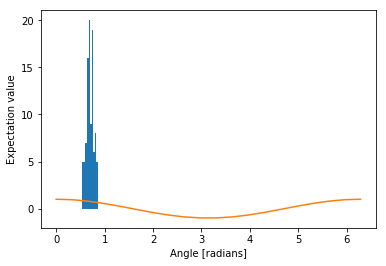

In [25]:
angle_range = np.linspace(0.0, 2 * np.pi, 20)
data = [vqe_inst.expectation(small_ansatz([angle]), hamiltonian, None, qvm)
        for angle in angle_range]

import matplotlib.pyplot as plt
plt.xlabel('Angle [radians]')
plt.ylabel('Expectation value')
plt.plot(angle_range, data)
plt.show()

Repeat this calculation with sampling, setting $N = 10, 100,$ and $1000$. In one sentence, what do you see?

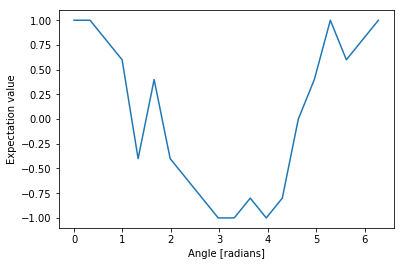

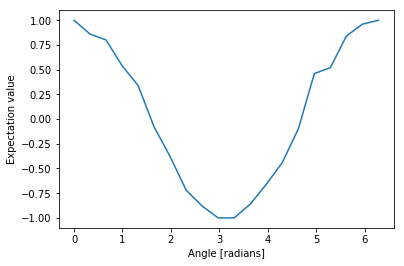

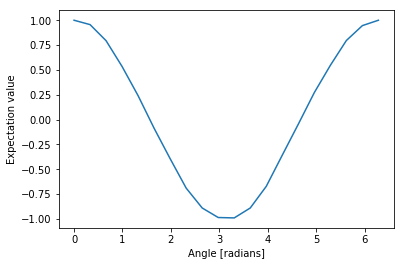

In [26]:
# repeating calculation with sampling, N = 10
angle_range = np.linspace(0.0, 2 * np.pi, 20)
data = [vqe_inst.expectation(small_ansatz([angle]), hamiltonian, 10, qvm)
        for angle in angle_range]
plt.xlabel('Angle [radians]')
plt.ylabel('Expectation value')
plt.plot(angle_range, data)
plt.show()

# repeating calculation with sampling, N = 100
angle_range = np.linspace(0.0, 2 * np.pi, 20)
data = [vqe_inst.expectation(small_ansatz([angle]), hamiltonian, 100, qvm)
        for angle in angle_range]
plt.xlabel('Angle [radians]')
plt.ylabel('Expectation value')
plt.plot(angle_range, data)
plt.show()

# repeating calculation with sampling, N = 1000
angle_range = np.linspace(0.0, 2 * np.pi, 20)
data = [vqe_inst.expectation(small_ansatz([angle]), hamiltonian, 1000, qvm)
        for angle in angle_range]
plt.xlabel('Angle [radians]')
plt.ylabel('Expectation value')
plt.plot(angle_range, data)
plt.show()

# In one sentence, what do you see?

As we can see, the curve is getting a lot smoother and moving towards an inverted Bell curve shape. This makes sense, as we sample more data points our probability distribution for the expectation value centers towards the average under a Bell-curve distribution. We can also see that as we get more sampling, we get closer and closer to the actual exact expectation value from the previous calculation, which also makes sense.

g) Finally, let's actually use our VQE (defined as vqe_inst above) to solve this problem.

In [27]:
result = vqe_inst.vqe_run(small_ansatz, hamiltonian, initial_angle, None, qvm=qvm)
print(result)

                     models will be ineffective
{'x': array([3.1415625]), 'fun': -0.9999999995453805}


The VQE returns the value of the parameter that minimizes $\langle H \rangle$ (in this case, $\theta = \pi$), along with the algorithm's estimate of the ground state energy (which in this case is quite accurate).

Explain why $\theta = \pi$ is the result we expect. (Hint: what do you have to do to the initial qubit state $|0\rangle$ to get to the ground state?)

# Why do we expect theta = pi?

When we are in the initial qubit state |0>, we have to apply the annihilation operator on it to get to the ground state. We know that the energy of |0> is 1/2 * hbar * omega (the vacuum energy). Every time the creation operator acts, we map |n> -> |n + 1>, and the opposite for the annihilation operator, which maps |n> -> |n - 1>.

When we take the annihilation operator on |0>, we remove hbar * omega of energy and thus if we define hbar and omega both as 1, we take -1, which is why we get an estimate of the ground state energy of -1 (assuming we are ommitting the 1/2 * hbar * omega vacuum state basic energy).

When we are taking a annihilation or creation operator, we perform a rotation of pi on the Bloch sphere (for instance, taking the creation annihilator rotates from |0>, which is pointing downwards, to |1>, which is pointing upward. This is a pi rotation on the Bloch sphere and the annihiliation operator performs the opposite operation, once again taking a pi rotation on the Bloch sphere). As a result, we execpt theta = pi because, as explained above, we need to take the annihilation operator to get to the ground state.

h) We could have chosen a quantum program with more than one variational parameter. Here's one example:

In [28]:
def smallish_ansatz(params):
    return Program(RX(params[0], 0), RX(params[1], 0))

print(smallish_ansatz([1.0, 2.0]))

vqe_inst = VQE(minimizer=minimize,
               minimizer_kwargs={'method': 'nelder-mead'})
initial_angles = [1.0, 1.0]
result = vqe_inst.vqe_run(smallish_ansatz, hamiltonian, initial_angles, None, qvm=qvm)
print(result)

RX(1.0) 0
RX(2.0) 0

                     models will be ineffective
{'x': array([1.62079632, 1.52079632]), 'fun': -1.0}


In one sentence, explain what the quantum program returned by the function "smallish_ansatz" does. Why might it be advantageous to have more than one variational parameter?

# What does "smallish_ansatz" do?

The function "smallish_ansatz" does the same thing as the function "small_ansatz", excepts that it applies two angle rotations subsequently to qubit 0 instead of only applying 1 angle rotation. This is equivalent to applying the "small_ansatz" function twice on two different angle parameters (or the same angles if we wanted to really). This might be advantageous if we have to perform an angle rotation in two directions (for example in the X and in the Y directions) or if we want to apply multiple rotations at one-time. Here we apply the rotation on the same axis both times (RX) but this could be different.

i) Make your own variational quantum eigensolver for the Hamiltonian $H = \sigma_x$. Bonus points will be awarded if you use three or more variational parameters in your quantum circuit and if you use a classical minimizer other than Nelder-Mead.

In [29]:
# we first define the Hamiltonian we want to solve
from pyquil.paulis import sX
hamiltonian2 = sX(0)

# define the 3 variational parameters smallish_ansatz2
def smallish_ansatz2(params):
    return Program(RX(params[0], 0), RY(params[1], 0), RZ(params[2], 0))

# specify starting angles
initial_angles2 = [1.0, 1.0, 1.0]

# define our new vqe_inst with a different method: Powell
# picked the Powell method from: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
# but could have picked any of the other options
vqe_inst2 = VQE(minimizer=minimize, minimizer_kwargs={'method': 'Powell'})

# run our VQE and display the result
result2 = vqe_inst2.vqe_run(smallish_ansatz2, hamiltonian2, initial_angles2, None, qvm=qvm)
print(result2)

                     models will be ineffective
{'x': array([4.2223832 , 1.57079633, 1.08079054]), 'fun': array(-1.)}


j) VQE was created to help solve challenging many-body Hamiltonians using quantum hardware. Let's take a step in that direction.

Write your own VQE to solve for the ground state of the three-qubit Hamiltonian $H = \sigma_x \otimes \sigma_y \otimes \sigma_z$. Show that the result given by your eigensolver agrees with the exact ground state energy, which you can compute using pyquil, QISKit, QuTiP, numpy, pen and paper, or any of the other tools we've discussed in this course.

In [30]:
# we first define the Hamiltonian we want to solve
from pyquil.paulis import sX, sY, sZ
hamiltonian_XYZ = sX(0) * sY(1) * sZ(2)

# define the variational parameters for our new ansatz
def smallish_ansatz_HXYZ(params):
    return Program(RX(params[0], 0), RY(params[1], 0), RZ(params[2],0),
                   RX(params[3], 1), RY(params[4], 1), RZ(params[5],1),
                   RX(params[6], 2), RY(params[7], 2), RZ(params[8],2))

# define our initial angles
initial_angles_HXYZ = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

# run our VQE
vqe_inst = VQE(minimizer=minimize, minimizer_kwargs={'method': 'nelder-mead'})

# get the results
result = vqe_inst.vqe_run(smallish_ansatz_HXYZ, hamiltonian_XYZ, initial_angles_HXYZ, None, qvm=qvm)
display(result)

# this agrees with what our other tools would have generated

                     models will be ineffective


{'fun': -0.9999999999814442,
 'x': array([ 7.79022465e-01,  1.57079914e+00,  7.79023522e-01,  1.57079438e+00,
         1.35989978e+00, -1.39644907e-06, -4.50827236e-06,  3.35082385e-06,
         2.57235214e+00])}